In [1]:
import numpy as np
import pandas as pd
import numpy.matlib
import scipy as sc
import random
import tensorflow as tf
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, LabelBinarizer
from sklearn.metrics import accuracy_score
# from lpproj import LocalityPreservingProjection
import matplotlib.pyplot as plt

# from lpproj import LocalityPreservingProjection

%matplotlib inline

Using TensorFlow backend.


In [2]:
def set_data(ntrain, ntest, nanc, non_iid='False'):
    
    (Xtrain, ytrain), (Xtest, ytest) = fashion_mnist.load_data()
    ind2 = np.random.choice(10000,ntest,replace=False)
    
    if non_iid == 'False':
        # random choice
        ind1 = np.random.choice(60000,ntrain, replace=False)
    else:
    # line up labels by protions of 50
        ind1= []
        for i in range(10):
            counter = 0
            for j, label in enumerate(ytrain):
                if label == i:
                    ind1.append(j)
                    counter += 1
                if counter >= 50:
                    break
        
#     if non_iid == 'Kinda':
#         ind1 = []
#         for i in range(10):
    
    if non_iid == 'Kinda':
        ind1 = np.hstack([ind1[25:], ind1[:25]])
    ind1 = ind1[:ntrain]

    
    Xtrain = Xtrain[ind1]
    ytrain = ytrain[ind1]
    Xtest = Xtest[ind2]
    ytest = ytest[ind2]
    
    
    # reshape
    Xtrain = normalize(Xtrain.reshape(Xtrain.shape[0], Xtrain.shape[1]*Xtrain.shape[2]))
    Xtest = normalize(Xtest.reshape(Xtest.shape[0], Xtest.shape[1]*Xtest.shape[2]))
    
    
    Xanc = make_anchors(nanc, Xtrain.shape[1], np.min(Xtrain), np.max(Xtrain))
    Xanc = normalize(Xanc)
    Xanc = Xtest
    
    return Xtrain, ytrain, Xtest, ytest, Xanc

In [3]:
# Simple KNN Classifier
def knn_cls(Xtrain, Xtest, ytrain, ytest): 
    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(Xtrain, ytrain.ravel())
    score = model.score(Xtest, ytest.ravel())
    
    return score

In [4]:
def set_anchor(Xtrain, n_anchors):
    Xave = (np.sum(Xtrain, 1) / np.size(Xtrain,1)).reshape(Xtrain.shape[0],1)
    Xdiv = np.sqrt(np.sum((Xtrain - Xave)**2, 1) / np.size(Xtrain, 1))
    Xcnt = (np.nanmax(Xtrain, axis=1) + np.nanmin(Xtrain, axis=1)) / 2
    Xrad = (np.nanmax(Xtrain, axis=1) - np.nanmin(Xtrain, axis=1)) / 2
    Xanc = (np.dot(Xcnt.reshape(Xcnt.shape[0], 1), np.ones((1, n_anchors))) 
            + 2 * Xrad.reshape(Xrad.shape[0], 1) * np.random.random((np.size(Xtrain,0), n_anchors)) - 0.5)
    return Xanc

In [5]:
# essential functions

def get_dc(colab, n_components):
    
    anc_merged = np.hstack([i['Yanc'] for i in colab])

    U, S, V = sc.linalg.svd(anc_merged, lapack_driver='gesvd')
    Z = U.T[:n_components,:]
    
    unified = []
    for i, user in enumerate(colab):
        G = np.dot(Z, np.linalg.pinv(user['Yanc'].T))
        mapping = np.dot(user['Y'], G.T)                   
        unified.append(mapping)
        # first user has training data
        if i == 0:
            transformed_test = np.dot(user['Ytest'], G.T)
    
    return unified, transformed_test

def get_embedding(X, anc, Xtest, d, method='SVD'):
    
    if method == 'PCA':
        F = PCA(d, svd_solver='full')
    
    elif method == 'ICA':
        F = FastICA(d)
        
    elif method == 'SRP':
        F = SparseRandomProjection(d)
    
    elif method == 'LLE':
        F = LocallyLinearEmbedding(n_neighbors=15, n_components=d)
 
    else:
        U1,S1,V1 = sc.linalg.svd(X, lapack_driver='gesvd')
        F = V1[:d,:]
        Y = np.dot(X, F.T)
        Yanc = np.dot(anc, F.T)
        Ytest = np.dot(Xtest, F.T)
        
        return Y, Yanc, Ytest
        
    Y = F.fit_transform(X)
    Yanc = F.transform(anc)
    Ytest = F.transform(Xtest)
    
    return Y, Yanc, Ytest

def make_anchors(nanc, m, mn, mx):
    
    anc = np.random.uniform(mn, mx, (nanc, m))
    
    return anc


def merge_anchors(Yanc1, Yanc2, dd):
    
    anc_merged = np.hstack([Yanc1, Yanc2])

    U, S, V = sc.linalg.svd(anc_merged, lapack_driver='gesvd')
    Z = U.T[:dd,:]

    G1 = np.dot(Z, np.linalg.pinv(Yanc1.T))
    anc1_h = np.dot(G1, Yanc1.T)
    G2 = np.dot(Z, np.linalg.pinv(Yanc2.T))
    anc2_h = np.dot(G2, Yanc2.T)
    
    return Z.T, anc1_h.T, anc2_h.T

In [6]:
def data_collaboration(Div_data, dd):
    colab = []
    for user in Div_data:
        Y, Yanc, Ytest = get_embedding(user['X'], user['Xanc'], user['Xtest'], dd, method='PCA')
        colab.append({'Y':Y, 'Yanc':Yanc, 'Ytest':Ytest })
    
#     # check anchor allignment
#     _, anch1, anch2 = merge_anchors(colab[0]['Yanc'], colab[1]['Yanc'], dd)
#     plt.scatter(anch1[:20,0], anch1[:20,1])
#     plt.scatter(anch2[:20,0], anch2[:20,1])
#     plt.title('Anchor allignment')

        
    unified_data, transformed_test = get_dc(colab, dd)
    X_all = np.vstack(unified_data)
    
    return X_all, transformed_test

In [7]:
# parameters
nparts = 5            # number of parties
ndat = 100            # size of data portions
ntest = 1000          # size of test data
ntrain = nparts*ndat  # size of all training data
nanc = 200           # number of anchor data
repeat = 10           # number of repeated experiments
dd=12

acc_cntr = np.zeros([repeat, nparts])
acc_ind = np.zeros([repeat, nparts])
acc_dc = np.zeros([repeat, nparts])

for r in range(repeat):
    random.seed(r)
    for ii in range(nparts):
        ntrain = ii*ndat + ndat
        Xtrain, ytrain, Xtest, ytest, Xanc = set_data(ntrain, ntest, nanc, non_iid='True')

        # pseudo-split of data
        Div_data = []
        for i in range(ii+1):
            start = i*ndat
            stop = i*ndat + ndat
            Div_data.append({'X':Xtrain[start:stop, :], 'y':ytrain[start:stop], 'Xanc':Xanc,
                             'Xtest':Xtest, 'ytest':ytest,}) 
        
#         # non-idd split
#         Div_data = []
#         labels = [i for i in range(np.max(ytrain)+1)]

#         for i in range(ii+1):
#             inds = [i for i, label in enumerate(ytrain) if label == labels[part] or label == labels[part+1]]
#             Div_data.append({'X':Xtrain[inds, :], 'y':ytrain[inds], 'Xanc':Xanc,
#                              'Xtest':Xtest, 'ytest':ytest,}) 
            

        # Main
        # train classifier on all data

        cntr = knn_cls(Xtrain, Xtest, ytrain, ytest)
        acc_cntr[r, ii] = cntr
        
        if ii == 0:
            # train classifier on data of one user
            ind = cntr
        acc_ind[r, ii] = ind


        # Proposed method
        X_dc, X_test_dc = data_collaboration(Div_data, dd)
        dc = knn_cls(X_dc, X_test_dc, ytrain, ytest)
        acc_dc[r, ii] = dc

knn_cntr = np.around(np.mean(acc_cntr, 0), decimals=2)
knn_ind = np.around(np.mean(acc_ind, 0), decimals=2)
knn_dc = np.around(np.mean(acc_dc, 0), decimals=2)

print('Averaged over {} runs'.format(repeat))
print('Centralized average accuracy:', knn_cntr)
print('Individual average accuracy:', knn_ind)
print('Collaboration average accuracy:', knn_dc)

Averaged over 10 runs
Centralized average accuracy: [0.19 0.35 0.49 0.59 0.73]
Individual average accuracy: [0.19 0.19 0.19 0.19 0.19]
Collaboration average accuracy: [0.19 0.27 0.32 0.4  0.41]


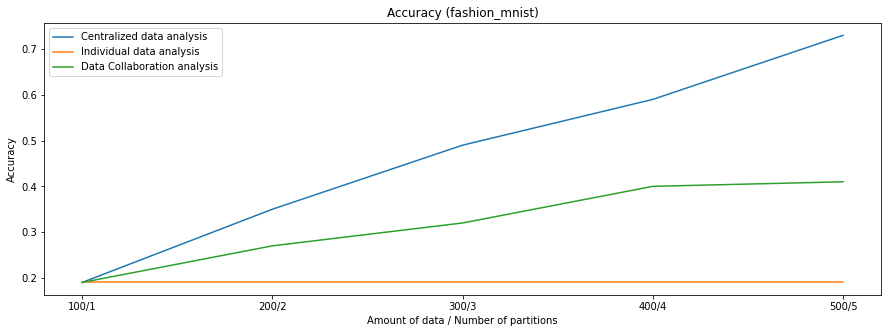

In [8]:
plt.figure(figsize=(15,5))
plt.plot(knn_cntr, label='Centralized data analysis')
plt.plot(knn_ind, label='Individual data analysis')
plt.plot(knn_dc, label='Data Collaboration analysis')
plt.ylabel('Accuracy')
plt.xlabel('Amount of data / Number of partitions')
locs, labels = plt.xticks()
plt.xticks(np.arange(0, 5, step = 1), ('100/1', '200/2', '300/3', '400/4', '500/5'))
plt.title("Accuracy (fashion_mnist)")
plt.legend()

# with Federated Learning

In [9]:
from collections import  Counter
Div_data = []
for i in range(nparts):
    start = i*ndat
    stop = i*ndat + ndat
    Div_data.append({'X':Xtrain[start:stop, :], 'y':ytrain[start:stop], 'Xanc':Xanc,
                      'Xtest':Xtest, 'ytest':ytest,})
    print(Counter(ytrain[start:stop]))

Counter({0: 50, 1: 50})
Counter({2: 50, 3: 50})
Counter({4: 50, 5: 50})
Counter({6: 50, 7: 50})
Counter({8: 50, 9: 50})


In [10]:
from tensorflow.python.keras.optimizer_v2 import gradient_descent
from tensorflow.keras import layers

def create_compiled_keras_model(dd):
    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Dense(512,activation="relu",input_shape=(dd,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)])
    
    def loss_fn(y_true, y_pred):
        return tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred))
    
    model.compile(
      loss=loss_fn,
      optimizer="adam",
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    return model


In [11]:
centralized_model = create_compiled_keras_model(Xtrain.shape[1])
cntr_history_callback =centralized_model.fit(Xtrain, ytrain, validation_data= (Xtest, ytest), batch_size=32, epochs=12) 

Train on 500 samples, validate on 1000 samples
Epoch 1/12
500/500 [==============================] - 0s 932us/sample - loss: 2.1175 - sparse_categorical_accuracy: 0.3800 - val_loss: 1.7984 - val_sparse_categorical_accuracy: 0.5840
Epoch 2/12
500/500 [==============================] - 0s 213us/sample - loss: 1.5114 - sparse_categorical_accuracy: 0.5460 - val_loss: 1.2253 - val_sparse_categorical_accuracy: 0.6420
Epoch 3/12
500/500 [==============================] - 0s 210us/sample - loss: 1.0553 - sparse_categorical_accuracy: 0.6500 - val_loss: 0.9404 - val_sparse_categorical_accuracy: 0.6800
Epoch 4/12
500/500 [==============================] - 0s 212us/sample - loss: 0.8788 - sparse_categorical_accuracy: 0.6860 - val_loss: 0.8369 - val_sparse_categorical_accuracy: 0.6920
Epoch 5/12
500/500 [==============================] - 0s 225us/sample - loss: 0.7524 - sparse_categorical_accuracy: 0.7540 - val_loss: 0.7655 - val_sparse_categorical_accuracy: 0.7360
Epoch 6/12
500/500 [=============

In [12]:
X_ind, y_ind = Div_data[0]['X'], Div_data[0]['y']
individual_model = create_compiled_keras_model(X_ind.shape[1])
ind_history_callback = individual_model.fit(X_ind, y_ind, validation_data=(Xtest, ytest),
                                            batch_size=32, epochs=12)

Train on 100 samples, validate on 1000 samples
Epoch 1/12
100/100 [==============================] - 0s 4ms/sample - loss: 2.1359 - sparse_categorical_accuracy: 0.5900 - val_loss: 2.3271 - val_sparse_categorical_accuracy: 0.1870
Epoch 2/12
100/100 [==============================] - 0s 588us/sample - loss: 1.4390 - sparse_categorical_accuracy: 0.8800 - val_loss: 2.6881 - val_sparse_categorical_accuracy: 0.1890
Epoch 3/12
100/100 [==============================] - 0s 586us/sample - loss: 0.7936 - sparse_categorical_accuracy: 0.9100 - val_loss: 3.7990 - val_sparse_categorical_accuracy: 0.1870
Epoch 4/12
100/100 [==============================] - 0s 601us/sample - loss: 0.4380 - sparse_categorical_accuracy: 0.9100 - val_loss: 5.2096 - val_sparse_categorical_accuracy: 0.1900
Epoch 5/12
100/100 [==============================] - 0s 584us/sample - loss: 0.2902 - sparse_categorical_accuracy: 0.8900 - val_loss: 6.4068 - val_sparse_categorical_accuracy: 0.1890
Epoch 6/12
100/100 [===============

In [13]:
X_dc, X_test_dc = data_collaboration(Div_data, dd)
dc_model = create_compiled_keras_model(X_dc.shape[1])
dc_history_callback = dc_model.fit(X_dc, ytrain, validation_data=(X_test_dc, ytest),
                                   batch_size=32, epochs=12)

Train on 500 samples, validate on 1000 samples
Epoch 1/12
500/500 [==============================] - 0s 694us/sample - loss: 2.2917 - sparse_categorical_accuracy: 0.2780 - val_loss: 2.2796 - val_sparse_categorical_accuracy: 0.3860
Epoch 2/12
500/500 [==============================] - 0s 113us/sample - loss: 2.2544 - sparse_categorical_accuracy: 0.3440 - val_loss: 2.2389 - val_sparse_categorical_accuracy: 0.3290
Epoch 3/12
500/500 [==============================] - 0s 110us/sample - loss: 2.1835 - sparse_categorical_accuracy: 0.4300 - val_loss: 2.1650 - val_sparse_categorical_accuracy: 0.3820
Epoch 4/12
500/500 [==============================] - 0s 109us/sample - loss: 2.0715 - sparse_categorical_accuracy: 0.3960 - val_loss: 2.0449 - val_sparse_categorical_accuracy: 0.4130
Epoch 5/12
500/500 [==============================] - 0s 113us/sample - loss: 1.9200 - sparse_categorical_accuracy: 0.4180 - val_loss: 1.9309 - val_sparse_categorical_accuracy: 0.4000
Epoch 6/12
500/500 [=============

# Anna-san's method 

In [15]:
initial_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

FedTrain = []
FedTest = []
FedAcc = []

for r in range(12):
    
    deltas = []

    for c in range(nparts):

        federated_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

        federated_model.set_weights(initial_model.get_weights())

        federated_model.fit(Div_data[c]['X'], Div_data[c]['y'], 
                                               batch_size=32, epochs=3, verbose=0)
        
        
        delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

        deltas.append(delta)
    print('Epoch {}/12'.format(r+1))
    delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
    new_weights = np.array(initial_model.get_weights()) - delt_av

    initial_model.set_weights(new_weights)
    
    FedTrain.append(initial_model.evaluate(Xtrain, ytrain)[0])
    validation = initial_model.evaluate(Xtest, ytest)
    FedTest.append(validation[0])
    FedAcc.append(validation[1])

Epoch 1/12
1000/1000 [==============================] - 0s 37us/sample - loss: 2.2116 - sparse_categorical_accuracy: 0.2410
Epoch 2/12
1000/1000 [==============================] - 0s 38us/sample - loss: 2.0709 - sparse_categorical_accuracy: 0.2910
Epoch 3/12
1000/1000 [==============================] - 0s 37us/sample - loss: 1.9293 - sparse_categorical_accuracy: 0.2880
Epoch 4/12
1000/1000 [==============================] - 0s 35us/sample - loss: 1.8017 - sparse_categorical_accuracy: 0.2850
Epoch 5/12
1000/1000 [==============================] - 0s 33us/sample - loss: 1.6943 - sparse_categorical_accuracy: 0.3270
Epoch 6/12
1000/1000 [==============================] - 0s 37us/sample - loss: 1.6216 - sparse_categorical_accuracy: 0.3450
Epoch 7/12
1000/1000 [==============================] - 0s 39us/sample - loss: 1.5620 - sparse_categorical_accuracy: 0.3630
Epoch 8/12
1000/1000 [==============================] - 0s 38us/sample - loss: 1.5097 - sparse_categorical_accuracy: 0.3880
Epoch 9/

In [16]:
# initial_model = create_compiled_keras_model(Div_data_dc[0].shape[1])

# DCFedTrain = []
# DCFedTest = []
# DCFedAcc = []

# for r in range(12):
    
#     deltas = []

#     for c in range(nparts):

#         federated_model = create_compiled_keras_model(Div_data_dc[0].shape[1])

#         federated_model.set_weights(initial_model.get_weights())

#         history_callback = federated_model.fit(Div_data_dc[c], Div_data[c]['y'], 
#                                                batch_size=32, epochs=1, verbose=0)

        
#         delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

#         deltas.append(delta)
#     print('Epoch {}/12'.format(r+1))
#     delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
#     new_weights = np.array(initial_model.get_weights()) - delt_av
#     initial_model.set_weights(new_weights)
    
#     DCFedTrain.append(initial_model.evaluate(X_dc, ytrain)[0])
#     validation = initial_model.evaluate(X_test_dc, ytest)
#     DCFedTest.append(validation[0])
#     DCFedAcc.append(validation[1])

Text(0.5, 1.0, 'Validation Accuracy, NN')

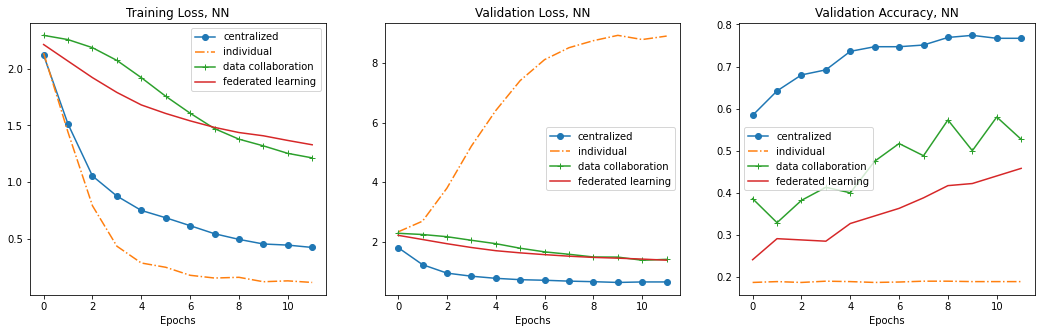

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


ax[0].plot(cntr_history_callback.history['loss'], '-o', label='centralized')
ax[0].plot(ind_history_callback.history['loss'], '-.', label='individual')
ax[0].plot(dc_history_callback.history['loss'], '-+',label='data collaboration')
ax[0].plot(FedTrain, label='federated learning')
# ax[0].plot(DCFedTrain, label='dc federated learning')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[0].set_title('Training Loss, NN')

ax[1].plot(cntr_history_callback.history['val_loss'], '-o',label='centralized')
ax[1].plot(ind_history_callback.history['val_loss'], '-.',label='individual')
ax[1].plot(dc_history_callback.history['val_loss'], '-+', label='data collaboration')
ax[1].plot(FedTest, label='federated learning')
# ax[1].plot(DCFedTest, label='dc federated learning')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[1].set_title('Validation Loss, NN')

ax[2].plot(cntr_history_callback.history['val_sparse_categorical_accuracy'], '-o', label='centralized')
ax[2].plot(ind_history_callback.history['val_sparse_categorical_accuracy'], '-.', label='individual')
ax[2].plot(dc_history_callback.history['val_sparse_categorical_accuracy'], '-+', label='data collaboration')
ax[2].plot(FedAcc, label='federated learning')
# ax[2].plot(DCFedAcc, label='dc federated learning')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[2].set_title('Validation Accuracy, NN')

# Akie's method

reference
- [pytorch](https://github.com/AshwinRJ/Federated-Learning-PyTorch/blob/master/src/utils.py)
- [kears](https://github.com/shaoxiongji/federated-learning/blob/f573d9c7a1c23d8e8360ec347efce2ad9dcd48be/models/Fed.py#L10)


In [18]:
initial_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

FedTrain = []
FedTest = []
FedAcc = []

for r in range(12):
    
    w_list, ndat_list = [], []
    # deltas = []

    for c in range(nparts):

        federated_model = create_compiled_keras_model(Div_data[0]['X'].shape[1])

        federated_model.set_weights(initial_model.get_weights())

        federated_model.fit(Div_data[c]['X'], Div_data[c]['y'], 
                                               batch_size=32, epochs=3, verbose=0)
        
        w_list.append(federated_model.get_weights())
        ndat_list.append(len(Div_data[c]['X']))
        
        # delta = np.array(initial_model.get_weights()) - np.array(federated_model.get_weights())

        # deltas.append(delta)
    print('Epoch {}/12'.format(r+1))
    # delt_av = (deltas[0] + deltas[1] + deltas[2] + deltas[3] + deltas[4]) / 5
    # new_weights = np.array(initial_model.get_weights()) - delt_av

    total_size = np.sum(ndat_list)
    new_weights = [np.zeros(w.shape) for w in initial_model.get_weights()]
    for w in range(len(new_weights)):
      for c in range(nparts):
        new_weights[w] += w_list[c][w] * ndat_list[c] / total_size

    initial_model.set_weights(new_weights)
    
    FedTrain.append(initial_model.evaluate(Xtrain, ytrain)[0])
    validation = initial_model.evaluate(Xtest, ytest)
    FedTest.append(validation[0])
    FedAcc.append(validation[1])

Epoch 1/12
1000/1000 [==============================] - 0s 35us/sample - loss: 2.2037 - sparse_categorical_accuracy: 0.1440
Epoch 2/12
1000/1000 [==============================] - 0s 37us/sample - loss: 2.0732 - sparse_categorical_accuracy: 0.3280
Epoch 3/12
1000/1000 [==============================] - 0s 39us/sample - loss: 1.9312 - sparse_categorical_accuracy: 0.3520
Epoch 4/12
1000/1000 [==============================] - 0s 36us/sample - loss: 1.8198 - sparse_categorical_accuracy: 0.3670
Epoch 5/12
1000/1000 [==============================] - 0s 38us/sample - loss: 1.7321 - sparse_categorical_accuracy: 0.3110
Epoch 6/12
1000/1000 [==============================] - 0s 42us/sample - loss: 1.6401 - sparse_categorical_accuracy: 0.3630
Epoch 7/12
1000/1000 [==============================] - 0s 35us/sample - loss: 1.5787 - sparse_categorical_accuracy: 0.3870
Epoch 8/12
1000/1000 [==============================] - 0s 62us/sample - loss: 1.5249 - sparse_categorical_accuracy: 0.4110
Epoch 9/

Text(0.5, 1.0, 'Validation Accuracy, NN')

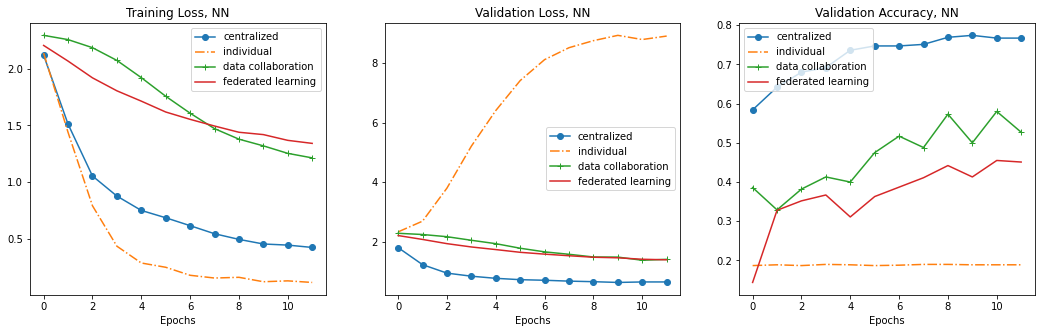

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))


ax[0].plot(cntr_history_callback.history['loss'], '-o', label='centralized')
ax[0].plot(ind_history_callback.history['loss'], '-.', label='individual')
ax[0].plot(dc_history_callback.history['loss'], '-+',label='data collaboration')
ax[0].plot(FedTrain, label='federated learning')
# ax[0].plot(DCFedTrain, label='dc federated learning')
ax[0].set_xlabel('Epochs')
ax[0].legend()
ax[0].set_title('Training Loss, NN')

ax[1].plot(cntr_history_callback.history['val_loss'], '-o',label='centralized')
ax[1].plot(ind_history_callback.history['val_loss'], '-.',label='individual')
ax[1].plot(dc_history_callback.history['val_loss'], '-+', label='data collaboration')
ax[1].plot(FedTest, label='federated learning')
# ax[1].plot(DCFedTest, label='dc federated learning')
ax[1].set_xlabel('Epochs')
ax[1].legend()
ax[1].set_title('Validation Loss, NN')

ax[2].plot(cntr_history_callback.history['val_sparse_categorical_accuracy'], '-o', label='centralized')
ax[2].plot(ind_history_callback.history['val_sparse_categorical_accuracy'], '-.', label='individual')
ax[2].plot(dc_history_callback.history['val_sparse_categorical_accuracy'], '-+', label='data collaboration')
ax[2].plot(FedAcc, label='federated learning')
# ax[2].plot(DCFedAcc, label='dc federated learning')
ax[2].set_xlabel('Epochs')
ax[2].legend()
ax[2].set_title('Validation Accuracy, NN')

still its wired to observe that DC is sperier to FL